In [13]:
%matplotlib widget
%load_ext autoreload
import numpy as np
import os 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.figure, matplotlib.axes
import os
import sys
import numpy as np
import pickle as pkl
import yaml
import tqdm
import collections.abc

thisfiledir=os.path.abspath("")
deepracingmodelsdir = os.path.abspath(os.path.join(thisfiledir, ".."))
deepracingdir = os.path.abspath(os.path.join(thisfiledir, "..", "..", "deepracing_py"))
if (not (deepracingmodelsdir in sys.path)) or (not (deepracingdir in sys.path)):
    sys.path = [deepracingmodelsdir, deepracingdir] + sys.path

mtrdir="/p/DeepRacing/MTR"
if (not (mtrdir in sys.path)):
    sys.path.insert(0, mtrdir)
print(sys.path)

class PredictionResults(collections.abc.Mapping[str,np.ndarray]):
    def __init__(self, resultsdict : dict[str,np.ndarray], data_dir : str, modelname : str) -> None:
        self.resultsdict = resultsdict
        self.data_dir = data_dir
        self.modelname = modelname
    def __iter__(self):
        return iter(self.resultsdict)
    def __len__(self):
        return len(self.resultsdict)
    def __getitem__(self, key):
        return self.resultsdict[key]
    def numsamples(self):
        return self.resultsdict["predictions"].shape[0]
    def keys(self):
        return self.resultsdict.keys()
    @staticmethod
    def from_data_file(data_file : str, modelname : str, sort_idx : np.ndarray | None = None) -> 'PredictionResults':
        data_dir = os.path.dirname(data_file)
        with open(data_file, "rb") as f:
            results_file = np.load(f)
            if sort_idx is None:
                results_dict = {k: v.copy() for (k,v) in results_file.items()}
            else:
                results_dict = {k: v[sort_idx].copy() for (k,v) in results_file.items()}
        return PredictionResults(results_dict, data_dir, modelname)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/p/DeepRacing/MTR', '/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch', '/l/ttw2xk/deepracingws/src/deepracing/deepracing_py', '/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting', '/p/DeepRacing/deepracingws/src/deepracing/DCNN-Pytorch', '/p/DeepRacing/deepracingws/src/deepracing/deepracing_py', '/l/ttw2xk/vcpkgexports/lambda_10_31_23/installed/x64-linux/lib/python311.zip', '/l/ttw2xk/vcpkgexports/lambda_10_31_23/installed/x64-linux/lib/python3.11', '/l/ttw2xk/vcpkgexports/lambda_10_31_23/installed/x64-linux/lib/python3.11/lib-dynload', '', '/l/ttw2xk/python3venvs/deepracing311/lib/python3.11/site-packages', '/l/ttw2xk/deepracingws/MTR', '/l/ttw2xk/source_builds/pytorch_cuda12', '/l/ttw2xk/python3venvs/deepracing311/lib/python3.11/site-packages/torchvision-0.16.0+fbb4cc5-py3.11-linux-x86_64.egg', '/l/ttw2xk/python3venvs/deepracing311/lib/python3.11/site-packages/torchaudio-2.1.0+6ea113

In [15]:
mixnet_experiment = "agricultural_flue_8932"
mixnet_results_dir = os.path.join("/p/DeepRacing/mixnet_results", mixnet_experiment)
mixnet_results = PredictionResults.from_data_file(os.path.join(mixnet_results_dir, "data.npz"), "MixNet")
print("Mixnet has %d points" % (mixnet_results.numsamples(),))

bezier_experiment = "widespread_beans_6059"
bezier_results_dir = os.path.join("/p/DeepRacing/mixnet_bezier_results", bezier_experiment)
bezier_results = PredictionResults.from_data_file(os.path.join(bezier_results_dir, "data.npz"), "BezierMixNet")
print("Mixnet Bezier has %d points" % (bezier_results.numsamples(),))

composite_experiment = "sunny_coyote_3579"
composite_results_dir = os.path.join("/p/DeepRacing/bamf_results", composite_experiment)
composite_results = PredictionResults.from_data_file(os.path.join(composite_results_dir, "data.npz"), "Composite Model")
print("Composite model has %d points" % (composite_results.numsamples(),))


mtr_experiment = "formal_pedestal_9890"
mtr_results_dir =  os.path.join("/p/DeepRacing/mtr_results/11_14_23", mtr_experiment)
mtr_data_dir = "/p/DeepRacing/unpacked_datasets/local_fitting/v1/mtr_format/1second"
mtr_scenarios_dir = os.path.join(mtr_data_dir, "processed_scenarios_test")
mtr_sortfile = os.path.join(mtr_results_dir, "test_plots", "idx_sort.npz")
if not os.path.isfile(mtr_sortfile):
    with open(os.path.join(mtr_data_dir, "processed_scenarios_test_infos.pkl"), "rb") as f:
        mtr_infos = pkl.load(f)
    mtr_keys = mtr_infos[0].keys()
    entries = []
    for (idx, info) in tqdm.tqdm(enumerate(mtr_infos), total=len(mtr_infos)):
        scenario_id = info["scenario_id"]
        with open(os.path.join(mtr_scenarios_dir, scenario_id+".metadata.yaml"), "r") as f:
            scenario_metadata = yaml.safe_load(f)
        deepracing_dir = os.path.dirname(scenario_metadata["deepracing_file"])
        dset_index = scenario_metadata["index"]
        car_index = int(os.path.basename(deepracing_dir).split("_")[-1])
        dated_trackname : str = os.path.basename(os.path.dirname(deepracing_dir))
        trackname = dated_trackname.split("_")[0]
        entries.append((idx, scenario_id, trackname, car_index, dset_index))
    entries_sorted = sorted(entries, key=lambda entry : (entry[2], entry[3], entry[4]))
    scenario_ids_sorted = np.asarray([e[1] for e in entries_sorted], dtype=object)
    idx_sort = np.asarray([e[0] for e in entries_sorted], dtype=np.int64)
    with open(mtr_sortfile, "wb") as f:
        np.savez(f, idx_sort=idx_sort, scenario_ids=scenario_ids_sorted)

with open(mtr_sortfile, "rb") as f:
    npfile = np.load(f, allow_pickle=True)
    sort_idx_mtr = npfile["idx_sort"].copy()
    scenario_ids_sorted = npfile["scenario_ids"].copy()

mtr_results = PredictionResults.from_data_file(os.path.join(mtr_results_dir, "test_plots", "data.npz"), "MTR", sort_idx=sort_idx_mtr)
print("MTR has %d points" % (mtr_results.numsamples(),))



Mixnet has 126577 points
Mixnet Bezier has 126577 points
Composite model has 126577 points
MTR has 126577 points


In [16]:
# idx_samp = 15
# best_curve_idx = mtr_results["best_curve_idx"]
# mtr_predictions = np.stack([mtr_results["predictions"][i, best_curve_idx[i]] for i in range(best_curve_idx.shape[0])], axis=0)
# comp_samp = composite_results["predictions"][idx_samp,1:]
# gt_samp = composite_results["ground_truth"][idx_samp,1:]
# mtr_samp = mtr_predictions[idx_samp]
def plot_error_histograms(data : dict[str, np.ndarray], modelname : str, bins=200, savedir : str | None = None):
    figures = []
    if (savedir is not None):
        os.makedirs(savedir, exist_ok=True)
    for (key, title) in {("ade", "MinADE"), ("lateral_error","Lateral Error"), ("longitudinal_error","Longitudinal Error")}:
        errors = data[key]
        fig : matplotlib.figure.Figure = plt.figure()
        plt.hist(errors, bins=bins)
        plt.title(title + ": " + modelname)
        figures.append(fig)
        if savedir is not None:
            fig.savefig(os.path.join(savedir, "%s_%s_histogram.png" % (modelname, key)), backend="agg")
            fig.savefig(os.path.join(savedir, "%s_%s_histogram.pdf" % (modelname, key)), backend="pdf")
        figbox : matplotlib.figure.Figure = plt.figure()
        plt.title(title + ": " + modelname)
        plt.boxplot(errors, notch=True)
        if savedir is not None:
            figbox.savefig(os.path.join(savedir, "%s_%s_boxplot.png" % (modelname, key)), backend="agg")
            figbox.savefig(os.path.join(savedir, "%s_%s_boxplot.pdf" % (modelname, key)), backend="pdf")
        figures.append(figbox)
    return figures


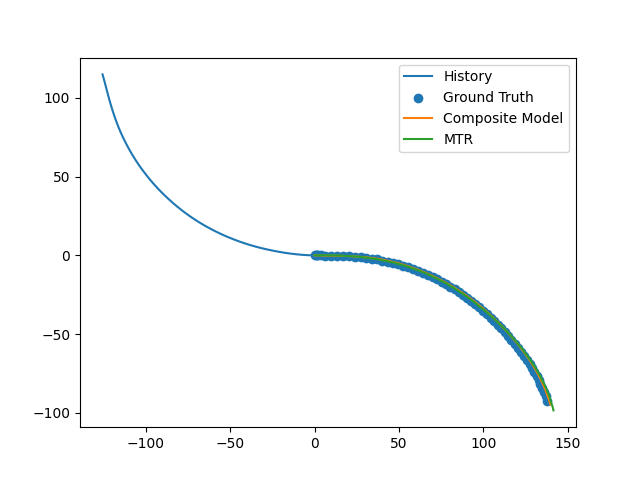

In [17]:
# figures = plot_error_histograms(mtr_results, "MTR", bins=200, savedir=mtr_results_dir)
# figures.extend(plot_error_histograms(composite_results, "Composite model", bins=200, savedir=composite_results_dir))
# figures.extend(plot_error_histograms(mixnet_results, "MixNet", bins=200, savedir=mixnet_results_dir))
# figures.extend(plot_error_histograms(bezier_results, "MixNet Bezier", bins=200, savedir=bezier_results_dir))
# print(os.listdir(mtr_results_dir))
# print(os.listdir(composite_results_dir))
# print(os.listdir(mixnet_results_dir))
# print(os.listdir(bezier_results_dir))
# plt.show()

error_sort = np.flip(np.argsort(mtr_results["ade"]), axis=0)
mtr_results_sorted = {k : mtr_results[k][error_sort] for k in mtr_results.keys()}
composite_results_sorted = {k : composite_results[k][error_sort] for k in composite_results.keys()}

idx = 3
gt_samp = composite_results_sorted["ground_truth"][idx]
history_samp = composite_results_sorted["history"][idx]
composite_samp = composite_results_sorted["predictions"][idx]
mtr_samp = mtr_results_sorted["predictions"][idx,mtr_results_sorted["best_curve_idx"][idx]]
mtr_samp = np.concatenate([(gt_samp[0,:2])[None], mtr_samp], axis=0)

fig = plt.figure()
plt.plot(history_samp[:,0], history_samp[:,1], label="History")
plt.scatter(gt_samp[:,0], gt_samp[:,1], label="Ground Truth")
# plt.plot(gt_samp[:,0], gt_samp[:,1], label="Ground Truth")
plt.plot(composite_samp[:,0], composite_samp[:,1], label="Composite Model")
plt.plot(mtr_samp[:,0], mtr_samp[:,1], label="MTR")
plt.legend()
plt.show()